## ATAC + MULTIOME (germ cells september 2021)

### Dimensionality reduction with cisTopic for single samples from cellatac

In [30]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

**r2py setup**

In [31]:
import rpy2.rinterface_lib.callbacks
import logging

In [32]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [33]:
import anndata2ri
anndata2ri.activate()

In [34]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [35]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
library(Signac)
library(cicero)

library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)
library(Seurat)
library(GenomeInfoDb)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

In [36]:
%%R 

writeLines(capture.output(sessionInfo()), "./sessionInfo.txt")

**Load data**

In [38]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/germcells_july2021/"
experiment_prefix = 'germcells_'

In [46]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

In [47]:
adata

AnnData object with n_obs × n_vars = 10387 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Setup of cisTopic**

In [48]:
# Remove empty rows
bool_matrix = adata.X.sum(0) > 0
bool_vector = np.squeeze(np.asarray(bool_matrix))
adata = adata[:, bool_vector]

In [49]:
adata

View of AnnData object with n_obs × n_vars = 10387 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Assess if there are cells with very low number of counts**

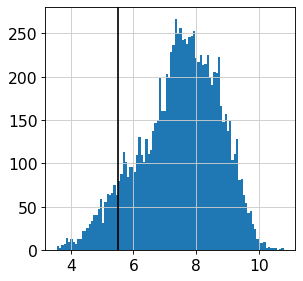

In [50]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=5.5, color="black")

**Convert anndata to SingleCellExperiment**

In [51]:
%%R -i adata -i outdir -i experiment_prefix
adata
#saveRDS(adata, paste0(outdir, experiment_prefix, "_SCE.RDS"))

class: SingleCellExperiment 
dim: 120127 10387 
metadata(0):
assays(2): X binary_raw
rownames(120127): chr1:818667-818886 chr1:827077-827691 ...
  chrY:26408786-26409779 chrY:26562951-26563265
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(10387): 01-AAACAGCCAGCCAGAA-1 01-AAACAGCCATCCAGGT-1 ...
  26-TGGCCTTCATCCCTCA-1 26-TGTGGCGAGACACAAT-1
colData names(10): cellatac_clusters n_genes_by_counts ...
  pct_counts_in_top_500_genes multiome_GermCells
reducedDimNames(0):
altExpNames(0):


**Train cisTopic model**

In [45]:
%%R -i outdir -i experiment_prefix

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

cisTopicObject
#saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_initialized_cisTopic.RDS"))

An object of class cisTopic in project ATAC_cisTopic 
 120127 regions across 10387 samples.


In [16]:
%%R -i outdir -i experiment_prefix

topics_vec <- c(10:30)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
                                   seed = 1712, 
                                   nCores = 21, 
                                   iterations = 500
                                  )

saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

[1] "Exporting data..."
[1] "Run models..."


In [52]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

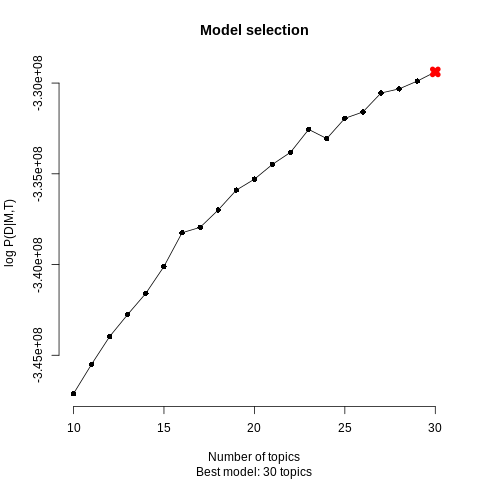

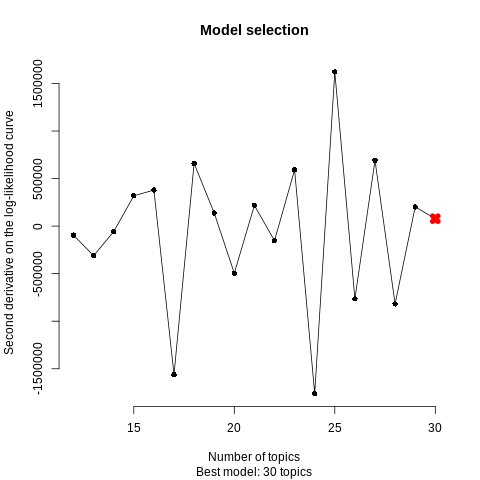

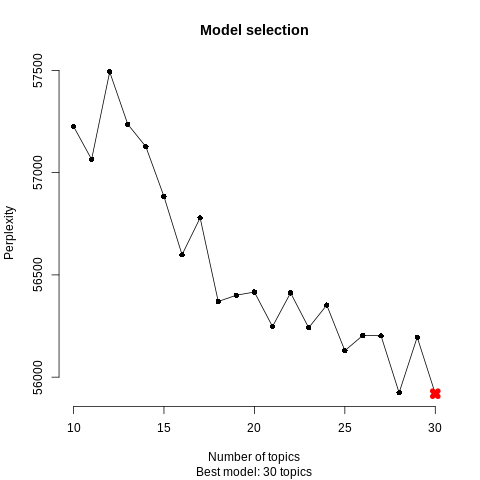

In [53]:
%%R

cistopic_model <- selectModel(cisTopicObject, type = 'maximum')

In [54]:
%%R -o topicXcell
## Save topic matrix ##
topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')

dim(topicXcell)

[1]    30 10387


In [55]:
topicXcell

array([[0.03386613, 0.02900875, 0.03538462, ..., 0.00996091, 0.07134579,
        0.05304477],
       [0.04535465, 0.0095481 , 0.00517094, ..., 0.00073838, 0.04679439,
        0.00649649],
       [0.07622378, 0.00335277, 0.00337607, ..., 0.00049225, 0.00057944,
        0.00039216],
       ...,
       [0.06323676, 0.02259475, 0.01358974, ..., 0.2441581 , 0.00961682,
        0.01584166],
       [0.02417582, 0.02368805, 0.00598291, ..., 0.03657159, 0.03483178,
        0.02876064],
       [0.0024975 , 0.0388484 , 0.01435897, ..., 0.01788041, 0.0618785 ,
        0.03751387]])

In [56]:
adata.obsm['X_cistopic_30'] = topicXcell.T

**Visualize dimensionality reduction results**

In [57]:
sc.pp.neighbors(adata, n_neighbors=8, use_rep="X_cistopic_30")

In [58]:
sc.tl.umap(adata, min_dist = 0.5, spread = 1)

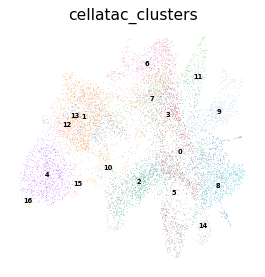

In [59]:
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)


In [60]:
colors = ['royalblue', 'orange', 'green', 'lightgrey','red', 'orchid',  'brown', 'pink', 'yellowgreen', 
                'deepskyblue']

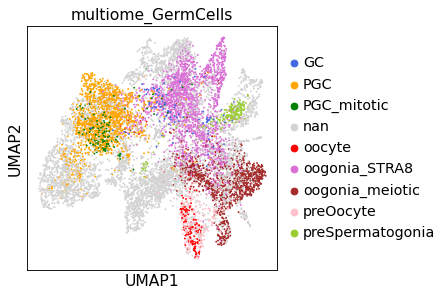

In [61]:
sc.pl.umap(adata, color = ['multiome_GermCells'], palette = colors)

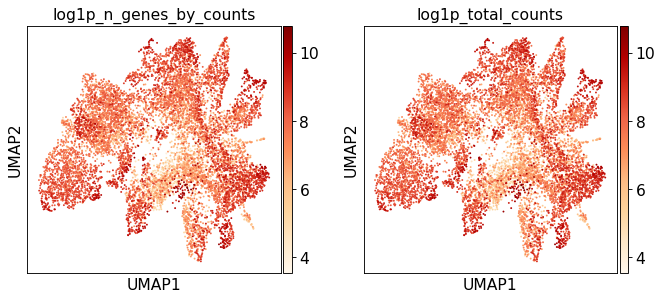

In [62]:
sc.pl.umap(adata, color = ['log1p_n_genes_by_counts', 'log1p_total_counts'], ncols = 2, color_map = "OrRd")

**Add metadata for females**

In [63]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

05    1878
15    1237
02    1219
01    1164
04     957
03     720
16     429
19     416
14     414
24     351
25     293
20     292
18     228
07     216
17     148
10     120
23      94
22      46
06      39
09      38
21      33
26      18
12      15
13       9
11       7
08       6
Name: code, dtype: int64

In [64]:
# Sample from code 
sample_dictionary = {'01' : 'FCA_GND10288176', '02' : 'FCA_GND10288177', '03' : 'FCA_GND10288178', 
                    '04' : 'FCA_GND10288179', '05' : 'FCA_GND10288180', '06' : 'FCA_GND8046539', 
                     '07' : 'FCA_GND8768481', '08' : 'FCA_GND8768482', '09' : 'FCA_GND8768484', 
                     '10' : 'FCA_GND8768485', '11' : 'FCA_GND8795927', '12' : 'FCA_GND8795928', 
                    '13' : 'FCA_GND9332157', '14' : 'HCA_F_GON10535399', '15' : 'HCA_F_GON10687818', 
                    '16' : 'HCA_F_GON10687819', '17' : 'HCA_F_GON10687820', '18' : 'HD_F_GON9479873',
                    '19' : 'HD_F_GON9479874', '20' : 'HD_F_GON9479875', '21' : 'HD_F_GON9525611',
                    '22' : 'HD_F_GON9525612', '23' : 'HD_F_GON9883955', '24' : 'HD_F_GON9883958', 
                    '25' : 'HD_F_GON9883959', '26' : 'HD_F_GON9883960'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

FCA_GND10288180      1878
HCA_F_GON10687818    1237
FCA_GND10288177      1219
FCA_GND10288176      1164
FCA_GND10288179       957
FCA_GND10288178       720
HCA_F_GON10687819     429
HD_F_GON9479874       416
HCA_F_GON10535399     414
HD_F_GON9883958       351
HD_F_GON9883959       293
HD_F_GON9479875       292
HD_F_GON9479873       228
FCA_GND8768481        216
HCA_F_GON10687820     148
FCA_GND8768485        120
HD_F_GON9883955        94
HD_F_GON9525612        46
FCA_GND8046539         39
FCA_GND8768484         38
HD_F_GON9525611        33
HD_F_GON9883960        18
FCA_GND8795928         15
FCA_GND9332157          9
FCA_GND8795927          7
FCA_GND8768482          6
Name: sample, dtype: int64

... storing 'code' as categorical
... storing 'sample' as categorical


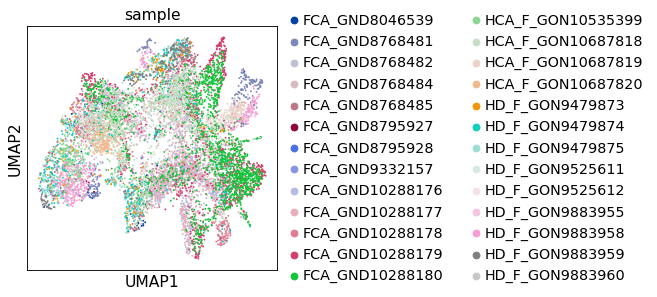

In [65]:
sc.pl.umap(adata, color = 'sample')

In [66]:
sex_dictionary = {'HCA_F_GON10535399' : 'female', 'HCA_F_GON10687818' : 'female', 'FCA_GND8046539' : 'female', 
                    'FCA_GND8768483' : 'female', 'FCA_GND8768484' : 'female', 'FCA_GND8768485' : 'female', 
                     'HD_F_GON9479873' : 'female', 'HD_F_GON9479874' : 'female', 'HD_F_GON9479875' : 'female', 
                'HD_F_GON9883959' : 'female', 'HD_F_GON9883960' : 'female', 
                   'FCA_GND10288176' : 'female', 'FCA_GND10288177' : 'female', 'FCA_GND10288178' : 'female', 
                    'FCA_GND10288179' : 'female', 'FCA_GND10288180' : 'female', 
                 'HCA_F_GON10687819' : 'male', 'HCA_F_GON10687820' : 'male', 'FCA_GND8768481' : 'male', 
                   'FCA_GND8768482' : 'male', 'FCA_GND8768487' : 'male', 'FCA_GND8795927' : 'male',
                     'FCA_GND8795928' : 'male', 'HD_F_GON9479872' : 'male', 'HD_F_GON9525611' : 'male', 
                     'HD_F_GON9525612' : 'male', 'FCA_GND9332157' : 'male', 'HD_F_GON9883958' : 'male',
                     'HD_F_GON9883955' : 'male'}
adata.obs['sex'] = adata.obs['sample'].map(sex_dictionary)
adata.obs['sex'].value_counts(dropna = False)

female    9033
male      1354
Name: sex, dtype: int64

In [67]:
stage_dictionary = {'FCA_GND8046539' : '8 PCW', 'FCA_GND8768484' : '8 PCW', 'FCA_GND8768483' : '14 PCW', 
                    'HD_F_GON9479874' : '14 PCW', 'HD_F_GON9479873' : '13 PCW',
                  'HD_F_GON9479875' : '14 PCW', 
                    'FCA_GND8768485' : '9 PCW', 
                   'HD_F_GON9883959' : '18 PCW', 'HD_F_GON9883960' : '21 PCW', 
                   'FCA_GND10288176' : '21 PCW', 
                 'FCA_GND10288177' : '21 PCW', 'FCA_GND10288178' : '14 PCW', 'FCA_GND10288179' : '20 PCW', 
                 'FCA_GND10288180' : '20 PCW', 'HCA_F_GON10535399' : '8.6 PCW', 'HCA_F_GON10687818' : '13 PCW',
                    'HCA_F_GON10687819' : '19 PCW', 'HCA_F_GON10687820' : '8.8 PCW', 'FCA_GND8768481' : '19 PCW', 
                   'FCA_GND8768482' : '9 PCW', 'FCA_GND8768487' : '12 PCW', 'FCA_GND8795927' : '7 PCW',
                     'FCA_GND8795928' : '12 PCW', 'HD_F_GON9479872' : '15 PCW', 'HD_F_GON9525611' : '12 PCW', 
                     'HD_F_GON9525612' : '12 PCW', 'FCA_GND9332157' : '17 PCW', 'HD_F_GON9883958' : '21 PCW',
                     'HD_F_GON9883955' : '17 PCW'
                  }
adata.obs['stage'] = adata.obs['sample'].map(stage_dictionary)
adata.obs['stage'].value_counts(dropna = False)

20 PCW     2835
21 PCW     2752
13 PCW     1465
14 PCW     1428
19 PCW      645
8.6 PCW     414
18 PCW      293
8.8 PCW     148
9 PCW       126
17 PCW      103
12 PCW       94
8 PCW        77
7 PCW         7
Name: stage, dtype: int64

In [68]:
individual_dictionary = {'FCA_GND8046539' : 'F81', 'FCA_GND8768484' : 'Hrv12', 'FCA_GND8768483' : 'Hrv11', 
                    'HD_F_GON9479874' : 'Hrv50', 'HD_F_GON9479871' : 'Hrv39', 'HD_F_GON9479873' : 'Hrv49',
                  'HD_F_GON9479875' : 'Hrv50', 
                    'FCA_GND8768485' : 'Hrv13', 
                        'HD_F_GON9883959' : 'Hrv59', 'HD_F_GON9883960' : 'Hrv58', 
                         'FCA_GND10288176' : 'Hrv58', 
                 'FCA_GND10288177' : 'Hrv58', 'FCA_GND10288178' : 'Hrv39', 'FCA_GND10288179' : 'Hrv65', 
                 'FCA_GND10288180' : 'Hrv65', 'HCA_F_GON10535399' : 'Hrv92', 'HCA_F_GON10687818' : 'Hrv91', 
                         'HCA_F_GON10687819' : 'Hrv3', 'HCA_F_GON10687820' : 'Hrv41', 'FCA_GND8768481' : 'Hrv3', 
                   'FCA_GND8768482' : 'Hrv10', 'FCA_GND8768487' : 'Hrv15', 'FCA_GND8795927' : 'Hrv17',
                     'FCA_GND8795928' : 'Hrv18', 'HD_F_GON9479872' : 'Hrv40', 'HD_F_GON9525611' : 'Hrv15', 
                     'HD_F_GON9525612' : 'Hrv15', 'FCA_GND9332157' : 'Hrv21', 'HD_F_GON9883958' : 'Hrv54',
                     'HD_F_GON9883955' : 'Hrv55'
                        }
adata.obs['individual'] = adata.obs['sample'].map(individual_dictionary)
adata.obs['individual'].value_counts(dropna = False)

Hrv65    2835
Hrv58    2401
Hrv91    1237
Hrv39     720
Hrv50     708
Hrv3      645
Hrv92     414
Hrv54     351
Hrv59     293
Hrv49     228
Hrv41     148
Hrv13     120
Hrv55      94
Hrv15      79
F81        39
Hrv12      38
Hrv18      15
Hrv21       9
Hrv17       7
Hrv10       6
Name: individual, dtype: int64

#### Plot metadata information

... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'individual' as categorical


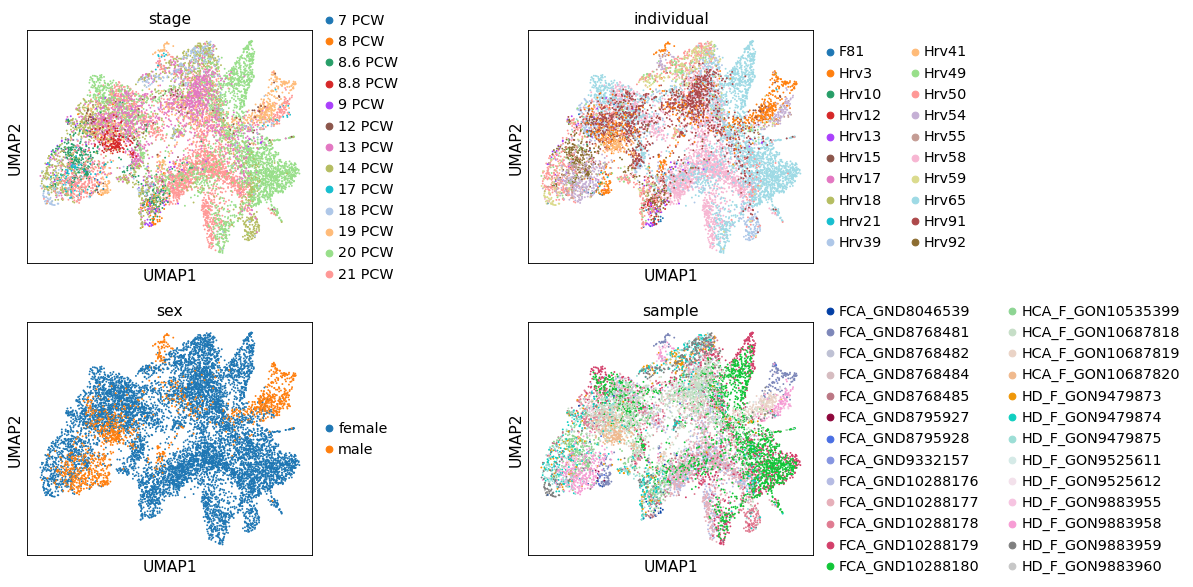

In [69]:
sc.pl.umap(adata, color = ['stage', 'individual', 'sex', 'sample'], ncols = 2, wspace = 0.6)

#### De-noising the peak x cell matrix with cisTopic

The learnt LDA model from cisTopic can be used to generate a de-noised accessibility matrix. From the paper:

cisTopic calculates the predictive distribution, which describes the probability of each region in each cell, by multiplying the topic–cell and the region–topic distributions:
𝑃(𝑟𝑖|𝑐𝑗)=∑𝑘=1𝐾𝑃(𝑟𝑖|𝑇𝑘)𝑃(𝑇𝑘|𝑐𝑗)
 
where

 * 𝑃(𝑟𝑖|𝑐𝑗)  is the probability of region i in cell j,
 * 𝑃(𝑟𝑖|𝑇𝑘)  is the probability of region i in topic k, and
 * 𝑃(𝑇𝑘|𝑐𝑗)  is the probability of topic k in cell j.

In [70]:
#%%R 

#install.packages("bigmemory")

In [71]:
%%R -o p_mat

library(bigmemory)
p_mat <- predictiveDistribution(cistopic_model, big.matrix=FALSE)

In [72]:
%%R
dim(p_mat)

[1] 120127  10387


In [73]:
p_mat

array([[4.99598056e-06, 1.87498179e-06, 1.19299342e-06, ...,
        1.69785626e-06, 1.29666780e-06, 1.62291987e-06],
       [2.39911412e-05, 1.30984334e-05, 1.95286024e-05, ...,
        1.61780274e-05, 1.42097637e-05, 1.12806001e-05],
       [1.59433613e-05, 1.58372179e-05, 1.66257767e-05, ...,
        1.36673491e-05, 1.73760233e-05, 1.63675996e-05],
       ...,
       [3.82828886e-07, 2.63143137e-07, 2.23371737e-07, ...,
        8.82680335e-07, 5.39977758e-07, 7.80408696e-07],
       [1.23369223e-06, 4.95943334e-07, 6.00414030e-07, ...,
        1.69557109e-06, 1.61785175e-06, 1.41183753e-06],
       [6.70622139e-07, 3.03352113e-07, 2.80208379e-07, ...,
        1.48765507e-06, 8.25615394e-07, 1.29183710e-06]])

#### Important: 

cistopic_p is a numpy array (cannot convert to sparse matrix because it crashes), and it is too large to save --> will save it in a separate object

In [74]:
adata.layers["cistopic_p"] = p_mat.T

#### Calculate de-noised gene scores

The de-noised accessibility signal can be used to calculate a gene-level accessibility scores (first implemented in Bravo Gonzales-Blas et al. 2020). This is very useful to check out accessibility of marker genes for example. From the paper:

we first multiply the region‐topic and topic‐cell distributions to obtain a region‐cell distribution, which indicates the probability of accessibility of each region in each cell. Then, for each gene, we aggregate the probabilities of the surrounding regions (in this case, 5 kb around the TSS plus introns), resulting in a gene activity score

At the moment there is no specific function in cisTopic to do this, but here is a simple implementation using functionality in GenomicRanges and Signac. Here I use peaks within a 5kb window of a gene (d parameter)

In [75]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
# library(Signac)

In [76]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  print("Got to here")
  print(typeof(length(all_peaks)))
  print(typeof(length(all_feats)))
  adj_mat <- Matrix::Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [77]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [79]:
%%R 
head(peaks_gr)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames        ranges strand
         <Rle>     <IRanges>  <Rle>
  [1]     chr1 818667-818886      *
  [2]     chr1 827077-827691      *
  [3]     chr1 869540-870172      *
  [4]     chr1 876378-877525      *
  [5]     chr1 902611-903058      *
  [6]     chr1 904097-904383      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths


In [41]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

[1] "Got to here"
[1] "integer"
[1] "integer"


In [42]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

### Alternative implementation of dot product between *adj_mat* and *p_mat*

In [43]:
print(np.__version__)

1.21.2


In [44]:
import math

#### adj_mat

In [45]:
rows_adj_mat = adj_mat.shape[0]
print(rows_adj_mat)
cols_adj_mat = adj_mat.shape[1]
print(cols_adj_mat)

16550
120127


In [46]:
a1 = adj_mat[0:math.ceil(rows_adj_mat/2), 0:math.ceil(cols_adj_mat/2)]
a2 = adj_mat[0:math.ceil(rows_adj_mat/2), math.ceil(cols_adj_mat/2):]
a3 = adj_mat[math.ceil(rows_adj_mat/2):, 0:math.ceil(cols_adj_mat/2)]
a4 = adj_mat[math.ceil(rows_adj_mat/2):, math.ceil(cols_adj_mat/2):]

In [47]:
print("a1 : {}\na2 : {}\na3 : {}\na4 : {}".format(a1.shape, a2.shape, a3.shape, a4.shape))

a1 : (8275, 60064)
a2 : (8275, 60063)
a3 : (8275, 60064)
a4 : (8275, 60063)


#### p_mat

In [48]:
rows_p_mat = p_mat.shape[0]
print(rows_p_mat)
cols_p_mat = p_mat.shape[1]
print(cols_p_mat)

120127
10387


In [49]:
b1 = p_mat[0:math.ceil(rows_p_mat/2), 0:math.ceil(cols_p_mat/2)]
b2 = p_mat[0:math.ceil(rows_p_mat/2), math.ceil(cols_p_mat/2):]
b3 = p_mat[math.ceil(rows_p_mat/2):, 0:math.ceil(cols_p_mat/2)]
b4 = p_mat[math.ceil(rows_p_mat/2):, math.ceil(cols_p_mat/2):]

In [50]:
print("b1 : {}\nb2 : {}\nb3 : {}\nb4 : {}".format(b1.shape, b2.shape, b3.shape, b4.shape))

b1 : (60064, 5194)
b2 : (60064, 5193)
b3 : (60063, 5194)
b4 : (60063, 5193)


#### Strassen matrix multiplication

In [51]:
c1 = np.add(a1.dot(b1), a2.dot(b3))

In [52]:
c1.shape

(8275, 5194)

In [53]:
c2 = np.add(a1.dot(b2), a2.dot(b4))

In [54]:
c2.shape

(8275, 5193)

In [55]:
c3 = np.add(a3.dot(b1), a4.dot(b3))

In [56]:
c3.shape

(8275, 5194)

In [57]:
c4 = np.add(a3.dot(b2), a4.dot(b4))

In [58]:
c4.shape

(8275, 5193)

In [59]:
c12 = np.concatenate((c1, c2), axis=1)

In [60]:
c12.shape

(8275, 10387)

In [61]:
c34 = np.concatenate((c3, c4), axis=1)

In [62]:
c34.shape

(8275, 10387)

In [63]:
gene_mat = np.concatenate((c12, c34), axis=0)

In [64]:
gene_mat.shape

(16550, 10387)

In [65]:
gene_mat

array([[9.10174112e-05, 6.72497897e-05, 6.49367110e-05, ...,
        7.04231654e-05, 6.73957737e-05, 6.03216311e-05],
       [3.61169916e-05, 2.13593880e-05, 1.84687407e-05, ...,
        4.31486462e-05, 1.93772144e-05, 1.93127964e-05],
       [3.61169916e-05, 2.13593880e-05, 1.84687407e-05, ...,
        4.31486462e-05, 1.93772144e-05, 1.93127964e-05],
       ...,
       [1.71042914e-06, 1.08156964e-06, 1.42833310e-06, ...,
        2.59074082e-06, 2.49691543e-06, 2.41696299e-06],
       [2.09195568e-06, 1.12445833e-06, 6.91041914e-07, ...,
        6.84732564e-07, 1.00467637e-06, 8.01669368e-07],
       [4.68501176e-06, 2.23593786e-06, 2.06489045e-06, ...,
        5.29831910e-06, 4.93652811e-06, 5.56900842e-06]])

In [66]:
# gene_mat = adj_mat.dot(p_mat) --> kills the kernel because both matrices need to be hold in memory 

Save another anndata object with the same .obs as the original one, but storing the gene score info.

In [67]:
%%R -i gene_mat -o predMatSumByGene

# Multiply and round predictive matrix to be able to integrate with scRNAseq data
predMatSumByGene <- round(gene_mat * 1000000)

In [68]:
gene_var = gene_var.set_index("gene_name")
gene_var.head()

,gene_id
gene_name,
RP11-54O7.16,ENSG00000272438
RP11-54O7.1,ENSG00000230699
RP11-54O7.2,ENSG00000241180
RP11-54O7.3,ENSG00000223764
SAMD11,ENSG00000187634


In [69]:
predMatSumByGene = predMatSumByGene.T
predMatSumByGene.shape

(10387, 16550)

In [70]:
gene_adata = anndata.AnnData(X=predMatSumByGene, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 10387 × 16550
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'

In [71]:
gene_adata.var_names_make_unique()

In [72]:
# Add cisTopic dimensionality reduction to match visualization 
gene_adata.obsm['X_cistopic_30'] = topicXcell.T

In [73]:
adata

AnnData object with n_obs × n_vars = 10387 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'multiome_GermCells_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_30', 'X_umap'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

In [74]:
del adata.layers['cistopic_p']

**Save anndata objects**

In [75]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [76]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

**Proceed with gene_data to look at marker genes**

In [77]:
sc.pp.neighbors(gene_adata, n_neighbors=8, use_rep="X_cistopic_30")

In [78]:
sc.tl.umap(gene_adata, min_dist = 0.5, spread = 1)

**Plot markers per cell type from RNA-seq**

In [79]:
mesothelial = ['LRRN4', 'UPK3B', 'KLK11'] 
gonad_somatic_cells = ['NR5A1', 'AMHR2', 'MIR202HG'] 
supporting = ['WNT6', 'WIPF3']
supporting_LGR5 = ['LGR5']
supporting_PAX8 = ['PAX8']
preGranulosa_lineage = ["KITLG",  'RSPO1', 'OSR1' , 'NR4A1']
granulosa_lineage = ['FOXL2', 'IRX3', 'CYP19A1', 'RDH10']
sertoli_lineage = ['SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA', 'TFF3', 'DKK3']
mesenchymal_steroidogenic = ['CYP11A1', 'CYP17A1', 'STAR',  'MGARP', 'FDXR']
leydigFetal_lineage = ['FDX1'] # Not there
leydig_lineage = ['INSL3', 'GLI1', 'HHIP', 'PTCH2']
preTheca_lineage = ['KIT', 'LHCGR'] # Not there
mesenchymal = ['DCN', 'PDGFRA','TCF21', 'OGN', 'POSTN']
gonadal_mesenchymal = ['LHX9', 'GATA4']
ovary_stroma = ['SPRR2F', 'AKR1C1', 'DIRAS3'] # Not there
testis_border_mesenhyme = ['IGF1', 'FGL2', 'PCSK2', 'ANGPTL1']
testis_myoid= ['PTCH1', 'NGFR', 'MSC', 'NEFL']
extragonadal_mesen = ['GATA2', 'NR2F1', 'WNT4', 'RSPO3', 'MEIS1', 'FAP']
mesoneprhic_stroma = ['CRABP1', 'ALX1',  'FOXD1']
gonad_dev = ['EMX2', 'WT1']
muscoskeletal = ['MYF5','PAX7','MYF6', 'MYLPF']
epithelial = ["EPCAM"]
PGCs= ['POU5F1', 'NANOG', 'NANOS3']
GCs = ['DAZL', 'DDX4']
immunePGCs= ['PTPRC']
endothelial = ['PECAM1', 'VWF', 'CDH5']
erythroid = ["GYPC", "HBA1"]
neural = ['ASCL1', 'ELAVL4']
PV = ["PDGFRB", 'ACTA2']
cycling = ['CDK1', 'MKI67'] # Not there
quiescent = ['CDKN1B']
male = ['SRY', 'RPS4Y1','DDX3Y'] # Not there

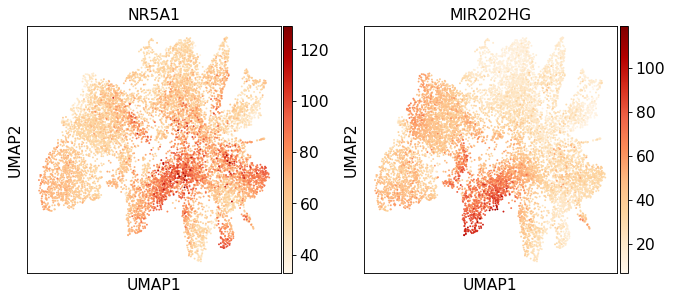

In [80]:
# Gonadal somatic
sc.pl.umap(gene_adata, color = ['NR5A1',  'MIR202HG'] , ncols = 3, color_map = 'OrRd')

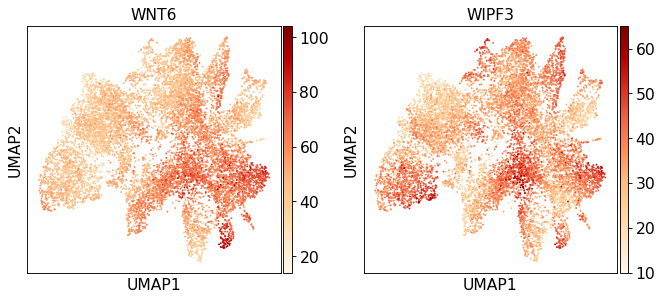

In [81]:
sc.pl.umap(gene_adata, color = supporting, ncols = 3, color_map = 'OrRd')

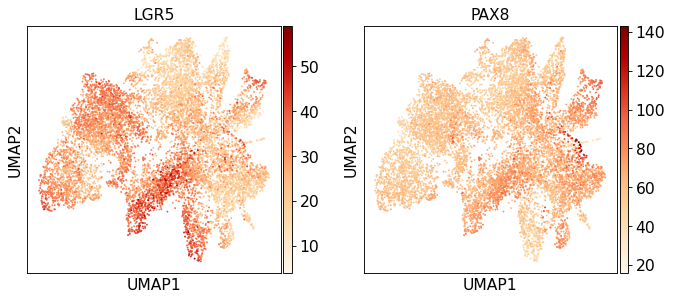

In [82]:
sc.pl.umap(gene_adata, color = ['LGR5', 'PAX8'], ncols = 3, color_map = 'OrRd')

In [83]:
# Pregranulosa
# sc.pl.umap(gene_adata, color = ["KITLG", 'OSR1' , 'NR4A1'], ncols = 3, color_map = 'OrRd')

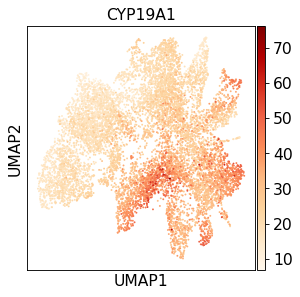

In [84]:
# Granulosa 
sc.pl.umap(gene_adata, color = ['CYP19A1'], ncols = 2, color_map = 'OrRd')

In [85]:
# Sertoli lineage
# sc.pl.umap(gene_adata, color = [ 'CLDN11', 'TFF3', 'DKK3'], ncols = 3, color_map = 'OrRd')

In [86]:
# Steroidogenic mesenchymal 
# sc.pl.umap(gene_adata, color = ['STAR',  'FDXR'], ncols = 3, color_map = 'OrRd')

In [87]:
# Leydig lineage
# sc.pl.umap(gene_adata, color = ['HHIP', 'PTCH2'], ncols = 3, color_map = 'OrRd')

In [88]:
# Mesenchymal 
#sc.pl.umap(gene_adata, color = ['DCN', 'PDGFRA','TCF21'], ncols = 3, color_map = 'OrRd')

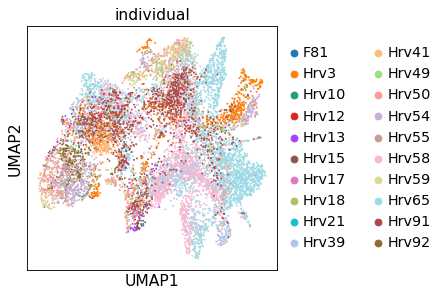

In [89]:
sc.pl.umap(gene_adata, color = 'individual')

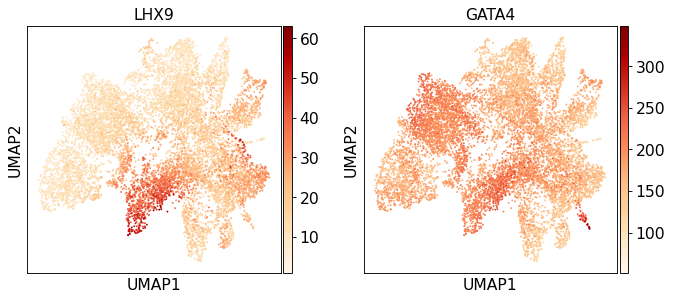

In [90]:
# Gonadal mesenchymal 
sc.pl.umap(gene_adata, color = ['LHX9', 'GATA4'], ncols = 3, color_map = 'OrRd')

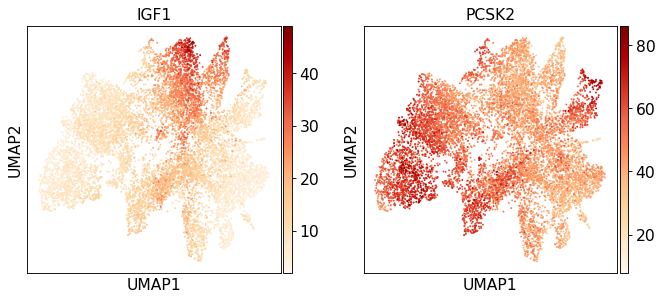

In [91]:
# Testis border mesenchyme
sc.pl.umap(gene_adata, color = ['IGF1', 'PCSK2'], ncols = 3, color_map = 'OrRd')

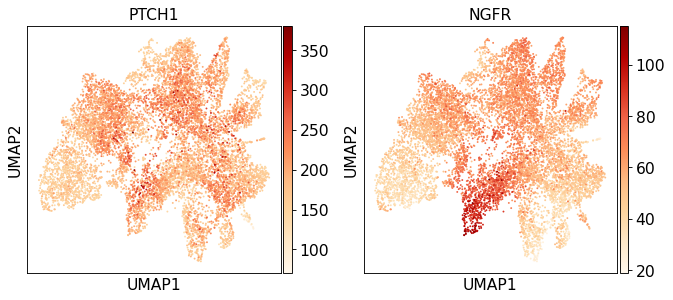

In [92]:
# Testis myoid
sc.pl.umap(gene_adata, color = ['PTCH1', 'NGFR'], ncols = 3, color_map = 'OrRd')

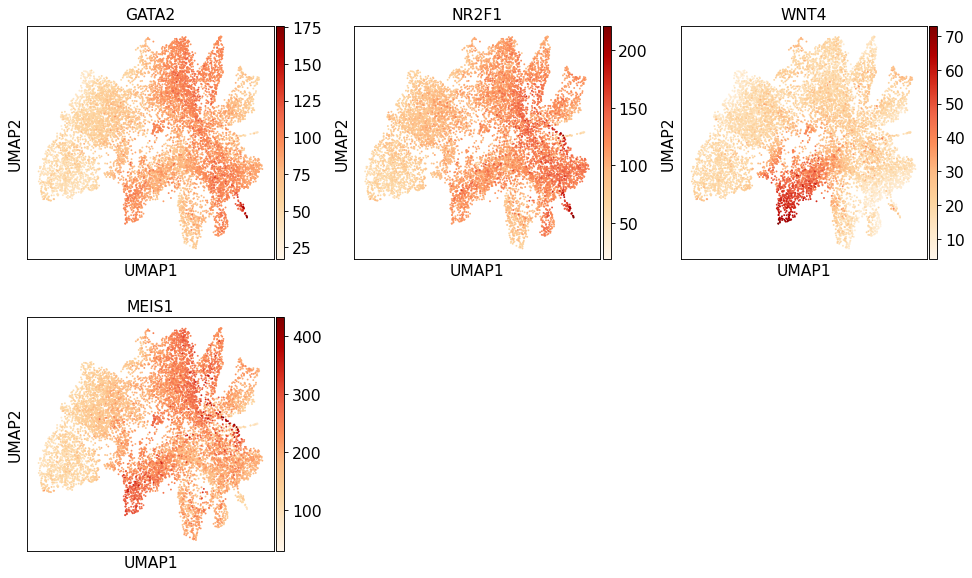

In [93]:
# Extragonal mesenchymal 
sc.pl.umap(gene_adata, color = ['GATA2', 'NR2F1', 'WNT4',  'MEIS1'], ncols = 3, color_map = 'OrRd')

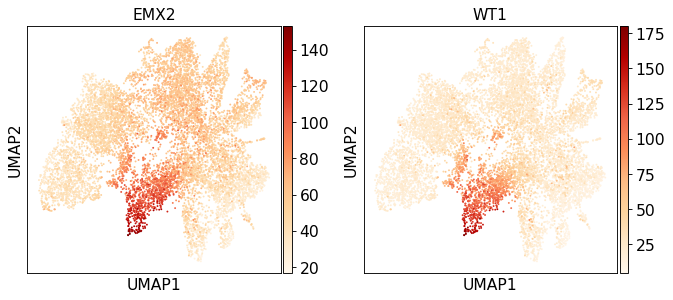

In [94]:
# Gonad dev
sc.pl.umap(gene_adata, color = ['EMX2', 'WT1'], ncols = 3, color_map = 'OrRd')

In [95]:
# Muscoskeletal 
# sc.pl.umap(gene_adata, color = ['PAX7','MYF6'], ncols = 3, color_map = 'OrRd')

In [96]:
# Epithelial and immune
#sc.pl.umap(gene_adata, color = [ 'EPCAM',  'LYVE1', 'CSF1R' 
#                                                           ], ncols = 3, color_map = 'OrRd')

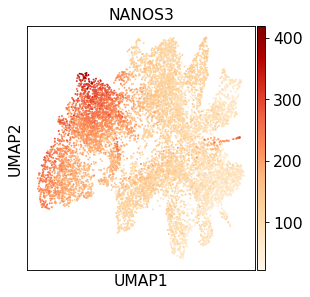

In [97]:
# PGC
sc.pl.umap(gene_adata, color = [ 'NANOS3'], ncols = 3, color_map = 'OrRd')

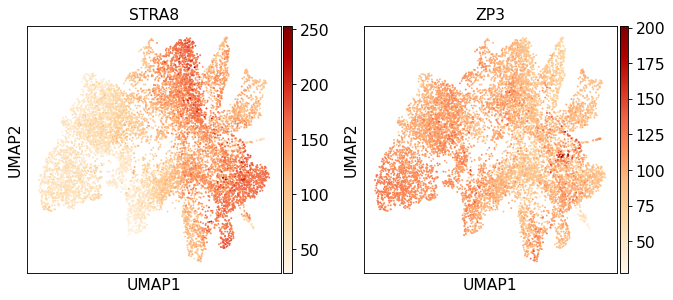

In [98]:
# Germ cells
sc.pl.umap(gene_adata, color = ['STRA8', 'ZP3'], ncols = 3, color_map = 'OrRd')

In [99]:
# Endothelial
# sc.pl.umap(gene_adata, color = ['PECAM1', 'VWF', 'CDH5'], ncols = 3, color_map = 'OrRd')

In [100]:
# Erythroid
# sc.pl.umap(gene_adata, color = ["GYPC"], ncols = 3, color_map = 'OrRd')

In [101]:
# Neural
# sc.pl.umap(gene_adata, color = ['ASCL1'], ncols = 3, color_map = 'OrRd')

In [102]:
# Perivascular
# sc.pl.umap(gene_adata, color = ["PDGFRB", 'ACTA2'], ncols = 3, color_map = 'OrRd')

In [103]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

### CICERO CCANs

In [16]:
barcodes = sc.read(outdir + experiment_prefix + '_harmony_ATACwCisTopic.h5ad')
barcodes

AnnData object with n_obs × n_vars = 8901 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'leiden_R', 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max', 'cell_type'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'germ_colors', 'germcells_colors', 'individual_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'multiome_GermCells_colors', 'neighbors', 'sample_colors', 'sex

In [17]:
adata = adata[barcodes.obs_names.to_list(), :]
adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 8901 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [18]:
ccans = pd.read_csv(outdir + experiment_prefix + "_ccans_annotated.csv", index_col = 0)
ccans = pd.DataFrame(ccans)
ccans.head()

,Peak,X,CCAN,peaks_formatted,peak_width,exon,gene_id,gene,gene_name,annotation,promoter,tss_distance,ENCODE_blacklist
1,chr1-100037590-100038967,chr1-100037590-100038967,1,chr1-100037590-100038967,1378,1,ENSG00000156875,1,MFSD14A,exon,1,0,0
2,chr1-100127250-100127797,chr1-100127250-100127797,542,chr1-100127250-100127797,548,0,ENSG00000156876,1,SASS6,intron,0,5157,0
3,chr1-100132344-100133411,chr1-100132344-100133411,540,chr1-100132344-100133411,1068,1,ENSG00000122435,1,TRMT13,exon,1,0,0
4,chr1-100150624-100151119,chr1-100150624-100151119,541,chr1-100150624-100151119,496,0,ENSG00000122477,1,LRRC39,intron,0,7716,0
5,chr1-1001795-1002058,chr1-1001795-1002058,35,chr1-1001795-1002058,264,0,ENSG00000187608,1,ISG15,promoter,1,649,0


In [22]:
peaksinCCANs = list(ccans['Peak'])

In [23]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]
cistopic = pd.DataFrame(adata.layers['cistopic_p'], index=adata.obs_names, columns=adata.var['peaks_formatted'])
cistopic.head()

Trying to set attribute `.var` of view, copying.


peaks_formatted,chr1-818667-818886,chr1-827077-827691,chr1-869540-870172,chr1-876378-877525,chr1-902611-903058,chr1-904097-904383,chr1-904561-904960,chr1-905223-905507,chr1-910003-910685,chr1-912790-913119,...,chrY-20575459-20576082,chrY-20756257-20756574,chrY-21310075-21310449,chrY-21404658-21404881,chrY-21676601-21677103,chrY-22308396-22308825,chrY-22373494-22373809,chrY-26359391-26359680,chrY-26408786-26409779,chrY-26562951-26563265
01-AAACAGCCAGCCAGAA-1,0.000005,0.000024,0.000016,0.000015,0.000011,0.000010,0.000020,0.000014,0.000018,0.000008,...,1.704500e-06,2.556965e-07,4.660986e-07,3.309529e-07,2.805508e-07,6.490663e-07,5.429716e-07,3.828289e-07,1.233692e-06,6.706221e-07
01-AAACAGCCATCCAGGT-1,0.000002,0.000013,0.000016,0.000007,0.000012,0.000014,0.000014,0.000006,0.000013,0.000005,...,7.086146e-07,2.642446e-07,2.020777e-07,1.703708e-07,1.963865e-07,3.340556e-07,2.790159e-07,2.631431e-07,4.959433e-07,3.033521e-07
01-AAACATGCATTGTCCT-1,0.000001,0.000020,0.000017,0.000004,0.000010,0.000010,0.000020,0.000007,0.000009,0.000007,...,8.752965e-07,2.336323e-07,2.909285e-07,2.552647e-07,3.187448e-07,1.535254e-07,2.730029e-07,2.233717e-07,6.004140e-07,2.802084e-07
01-AAACCGAAGCTTCCCG-1,0.000002,0.000019,0.000026,0.000013,0.000007,0.000012,0.000029,0.000004,0.000008,0.000005,...,2.090297e-06,2.387087e-07,3.213669e-07,2.292306e-07,2.234327e-07,1.260308e-06,7.790085e-07,5.548699e-07,1.212424e-06,1.085245e-06
01-AAACCGAAGGCGAATA-1,0.000002,0.000013,0.000013,0.000006,0.000010,0.000012,0.000016,0.000006,0.000013,0.000005,...,1.176047e-06,3.263971e-07,4.510935e-07,3.149297e-07,2.294150e-07,5.466705e-07,2.989899e-07,2.711175e-07,9.405983e-07,3.215849e-07


In [24]:
cells_peaksinCCANs = cistopic.loc[:, peaksinCCANs]
cells_peaksinCCANs.shape

(8901, 41353)

In [20]:
adata.obs['cell_type'] = adata.obs_names.map(barcodes.obs['cell_type'].to_dict())

In [21]:
adata.obs['sex'] = adata.obs_names.map(barcodes.obs['sex'].to_dict())

In [22]:
# Mapping of cells to cell types 
adata.obs['barcode'] = adata.obs_names
cells_celltypes = adata.obs[['barcode', 'cell_type', 'sex']]
cells_celltypes.head()

,barcode,cell_type,sex
01-AAACAGCCAGCCAGAA-1,01-AAACAGCCAGCCAGAA-1,oogonia_STRA8,female
01-AAACAGCCATCCAGGT-1,01-AAACAGCCATCCAGGT-1,oogonia_STRA8,female
01-AAACATGCATTGTCCT-1,01-AAACATGCATTGTCCT-1,oogonia_STRA8,female
01-AAACCGAAGCTTCCCG-1,01-AAACCGAAGCTTCCCG-1,pre_oocyte,female
01-AAACCGAAGGCGAATA-1,01-AAACCGAAGGCGAATA-1,oogonia_STRA8,female


In [28]:
cells_celltypes['cell_type'].value_counts()

PGC                  3016
oogonia_STRA8        2467
oogonia_meiotic      1466
GC                    903
pre_spermatogonia     459
oocyte                442
pre_oocyte            148
Name: cell_type, dtype: int64

In [30]:
cells_mapping = cells_celltypes.groupby('cell_type').groups
# Mean by rows 
for key in cells_mapping: 
    print(key)
    cells_peaksinCCANs.loc[key] = cells_peaksinCCANs.loc[cells_mapping[key]].mean(axis = 0)

GC
PGC
oocyte
oogonia_STRA8
oogonia_meiotic
pre_oocyte
pre_spermatogonia


In [31]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
cells_peaksinCCANs = cells_peaksinCCANs.loc[rows_celltypes, ]

['GC', 'PGC', 'oocyte', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_oocyte', 'pre_spermatogonia']


In [29]:
cells_peaksinCCANs.head()

peaks_formatted,chr1-100037590-100038967,chr1-100127250-100127797,chr1-100132344-100133411,chr1-100150624-100151119,chr1-1001795-1002058,chr1-100212963-100213630,chr1-100249254-100250136,chr1-100256361-100256991,chr1-100265586-100266851,chr1-10032434-10033504,...,chrX-9748955-9749362,chrX-97575860-97576458,chrX-97594451-97595026,chrX-97681143-97682086,chrX-9797105-9798181,chrX-980724-982149,chrX-9912313-9912869,chrX-9927932-9928482,chrX-9934060-9934630,chrX-9935559-9935893
01-AAACAGCCAGCCAGAA-1,0.000046,0.000007,0.000035,3.534258e-06,0.000010,0.000011,0.000027,0.000004,0.000023,0.000060,...,0.000003,0.000006,0.000007,2.210413e-06,0.000016,0.000019,0.000008,0.000002,0.000008,0.000005
01-AAACAGCCATCCAGGT-1,0.000059,0.000009,0.000055,9.838569e-07,0.000027,0.000007,0.000034,0.000004,0.000029,0.000096,...,0.000003,0.000008,0.000009,7.214517e-06,0.000010,0.000007,0.000003,0.000003,0.000012,0.000004
01-AAACATGCATTGTCCT-1,0.000073,0.000018,0.000071,4.245099e-07,0.000016,0.000007,0.000045,0.000004,0.000034,0.000107,...,0.000002,0.000018,0.000020,8.247251e-06,0.000008,0.000005,0.000002,0.000003,0.000024,0.000009
01-AAACCGAAGCTTCCCG-1,0.000047,0.000003,0.000057,4.884469e-06,0.000012,0.000007,0.000045,0.000002,0.000043,0.000106,...,0.000005,0.000002,0.000001,6.765000e-07,0.000009,0.000006,0.000002,0.000002,0.000002,0.000001
01-AAACCGAAGGCGAATA-1,0.000043,0.000009,0.000047,8.216266e-07,0.000020,0.000008,0.000024,0.000004,0.000030,0.000072,...,0.000002,0.000007,0.000008,7.652371e-06,0.000011,0.000007,0.000004,0.000004,0.000010,0.000004


In [30]:
# Mapping of peaks to CCANs 
ccans = ccans.set_index('peaks_formatted')
peaks_ccans = ccans[['Peak', 'CCAN']]
peaks_mapping = peaks_ccans.groupby('CCAN').groups

In [34]:
len([i for i in peaks_mapping])

2802

In [35]:
# Mean by columns 
for key in peaks_mapping: 
    #print(key)
    cells_peaksinCCANs[key] = cells_peaksinCCANs[peaks_mapping[key]].mean(axis = 1)

In [37]:
cells_peaksinCCANs.shape

(8901, 44155)

In [38]:
cols_ccans = list(np.unique(peaks_ccans['CCAN']))
# Select only aggregated rows and columns 
celltype_CCANs = cells_peaksinCCANs.loc[:, cols_ccans]
celltype_CCANs = celltype_CCANs.loc[(celltype_CCANs.sum(axis=1) != 0), (celltype_CCANs.sum(axis=0) != 0)]

In [39]:
celltype_CCANs.head()

peaks_formatted,1,2,5,7,11,12,13,18,20,22,...,6250,6251,6258,6261,6262,6263,6264,6265,6268,6269
01-AAACAGCCAGCCAGAA-1,0.000027,0.000003,0.000009,0.000008,0.000010,0.000013,0.000011,0.000030,0.000014,0.000017,...,0.000003,0.000003,0.000011,0.000005,0.000003,0.000005,0.000003,0.000008,0.000009,0.000005
01-AAACAGCCATCCAGGT-1,0.000033,0.000004,0.000010,0.000008,0.000009,0.000010,0.000011,0.000038,0.000016,0.000023,...,0.000002,0.000001,0.000020,0.000008,0.000001,0.000006,0.000002,0.000004,0.000005,0.000009
01-AAACATGCATTGTCCT-1,0.000036,0.000007,0.000008,0.000006,0.000007,0.000008,0.000011,0.000044,0.000019,0.000028,...,0.000002,0.000002,0.000020,0.000012,0.000002,0.000010,0.000002,0.000003,0.000005,0.000014
01-AAACCGAAGCTTCCCG-1,0.000035,0.000001,0.000014,0.000012,0.000012,0.000011,0.000011,0.000045,0.000016,0.000030,...,0.000003,0.000001,0.000016,0.000002,0.000001,0.000002,0.000005,0.000004,0.000004,0.000002
01-AAACCGAAGGCGAATA-1,0.000028,0.000004,0.000009,0.000008,0.000009,0.000010,0.000011,0.000033,0.000014,0.000022,...,0.000002,0.000003,0.000019,0.000007,0.000003,0.000006,0.000002,0.000005,0.000006,0.000009


### Before normalizing, find differentially accessible CCANs

In [42]:
celltype_CCANs_t = celltype_CCANs.T
celltype_CCANs_t.shape

(2802, 8901)

In [55]:
celltype_CCANs_t.head()

,01-AAACAGCCAGCCAGAA-1,01-AAACAGCCATCCAGGT-1,01-AAACATGCATTGTCCT-1,01-AAACCGAAGCTTCCCG-1,01-AAACCGAAGGCGAATA-1,01-AAACCGAAGTTCCTGC-1,01-AAACCGGCAAGGTATA-1,01-AAACGGATCCTAAGTA-1,01-AAAGCAAGTACGGTAC-1,01-AAAGCAAGTTAACACG-1,...,26-CGGACTGGTCACAGTT-1,26-CTTCTAAAGTCCGATT-1,26-GAGGATGAGATAGGTT-1,26-GCGCCAACAGATTAAG-1,26-TCACCTGTCTGCTACC-1,26-TCGGGACGTCTGATTG-1,26-TCTCAGCAGTATACCC-1,26-TGAGCCGAGTACAGAT-1,26-TGGCCTTCATCCCTCA-1,26-TGTGGCGAGACACAAT-1
peaks_formatted,,,,,,,,,,,,,,,,,,,,,
1,0.000027,0.000033,0.000036,0.000035,0.000028,0.000024,0.000023,0.000031,0.000032,0.000023,...,0.000037,0.000042,0.000046,0.000028,0.000030,0.000022,0.000033,0.000022,0.000037,0.000032
2,0.000003,0.000004,0.000007,0.000001,0.000004,0.000003,0.000003,0.000003,0.000002,0.000003,...,0.000001,0.000006,0.000001,0.000010,0.000007,0.000002,0.000007,0.000001,0.000005,0.000011
5,0.000009,0.000010,0.000008,0.000014,0.000009,0.000009,0.000002,0.000013,0.000010,0.000009,...,0.000013,0.000013,0.000015,0.000004,0.000005,0.000003,0.000005,0.000002,0.000010,0.000008
7,0.000008,0.000008,0.000006,0.000012,0.000008,0.000009,0.000003,0.000012,0.000008,0.000012,...,0.000011,0.000010,0.000011,0.000004,0.000005,0.000002,0.000004,0.000002,0.000008,0.000006
11,0.000010,0.000009,0.000007,0.000012,0.000009,0.000010,0.000002,0.000013,0.000009,0.000012,...,0.000011,0.000012,0.000013,0.000004,0.000005,0.000002,0.000004,0.000002,0.000009,0.000007


In [46]:
# Save matrix 
celltype_CCANs_t.to_csv(outdir + experiment_prefix + '_cellsxccans.csv')

In [11]:
celltype_CCANs_t = pd.read_csv(outdir + experiment_prefix + '_cellsxccans.csv', index_col = 0)
celltype_CCANs_t.head()

,01-AAACAGCCAGCCAGAA-1,01-AAACAGCCATCCAGGT-1,01-AAACATGCATTGTCCT-1,01-AAACCGAAGCTTCCCG-1,01-AAACCGAAGGCGAATA-1,01-AAACCGAAGTTCCTGC-1,01-AAACCGGCAAGGTATA-1,01-AAACGGATCCTAAGTA-1,01-AAAGCAAGTACGGTAC-1,01-AAAGCAAGTTAACACG-1,...,26-CGGACTGGTCACAGTT-1,26-CTTCTAAAGTCCGATT-1,26-GAGGATGAGATAGGTT-1,26-GCGCCAACAGATTAAG-1,26-TCACCTGTCTGCTACC-1,26-TCGGGACGTCTGATTG-1,26-TCTCAGCAGTATACCC-1,26-TGAGCCGAGTACAGAT-1,26-TGGCCTTCATCCCTCA-1,26-TGTGGCGAGACACAAT-1
peaks_formatted,,,,,,,,,,,,,,,,,,,,,
1,0.000027,0.000033,0.000036,0.000035,0.000028,0.000024,0.000023,0.000031,0.000032,0.000023,...,0.000037,0.000042,0.000046,0.000028,0.000030,0.000022,0.000033,0.000022,0.000037,0.000032
2,0.000003,0.000004,0.000007,0.000001,0.000004,0.000003,0.000003,0.000003,0.000002,0.000003,...,0.000001,0.000006,0.000001,0.000010,0.000007,0.000002,0.000007,0.000001,0.000005,0.000011
5,0.000009,0.000010,0.000008,0.000014,0.000009,0.000009,0.000002,0.000013,0.000010,0.000009,...,0.000013,0.000013,0.000015,0.000004,0.000005,0.000003,0.000005,0.000002,0.000010,0.000008
7,0.000008,0.000008,0.000006,0.000012,0.000008,0.000009,0.000003,0.000012,0.000008,0.000012,...,0.000011,0.000010,0.000011,0.000004,0.000005,0.000002,0.000004,0.000002,0.000008,0.000006
11,0.000010,0.000009,0.000007,0.000012,0.000009,0.000010,0.000002,0.000013,0.000009,0.000012,...,0.000011,0.000012,0.000013,0.000004,0.000005,0.000002,0.000004,0.000002,0.000009,0.000007


In [12]:
# Normalize by column (CCAN)
# Transpose 
celltype_CCANs = celltype_CCANs_t.T
from scipy.stats import zscore
celltype_CCANs_zscore = celltype_CCANs.apply(zscore)

In [13]:
celltype_CCANs_zscore.head()

peaks_formatted,1,2,5,7,11,12,13,18,20,22,...,6250,6251,6258,6261,6262,6263,6264,6265,6268,6269
01-AAACAGCCAGCCAGAA-1,-0.618805,-0.007765,0.129263,0.204624,0.301715,1.434945,-0.626653,-0.657851,-1.075402,-1.855066,...,0.412326,-0.265672,-0.467311,0.110660,-0.308068,0.207246,0.345159,0.017027,0.132335,0.083810
01-AAACAGCCATCCAGGT-1,0.261858,0.198345,0.292518,0.113201,0.211706,0.606362,-0.597830,0.268347,-0.132124,-0.892338,...,-0.054080,-0.740612,1.194749,0.810197,-0.732568,0.542612,0.035886,-0.822111,-0.568977,1.208791
01-AAACATGCATTGTCCT-1,0.552766,1.141003,-0.165238,-0.168049,-0.192783,-0.057498,-0.703916,0.908246,1.279805,-0.133877,...,-0.352827,-0.707569,1.115935,1.923496,-0.707032,1.510179,-0.162293,-0.931081,-0.725821,2.541918
01-AAACCGAAGCTTCCCG-1,0.461584,-0.715714,1.057292,0.838882,0.806259,1.017530,-0.662990,1.094059,-0.045635,0.210753,...,0.445442,-0.807264,0.409961,-0.647484,-0.771912,-0.607729,1.036129,-0.833265,-0.792675,-0.647055
01-AAACCGAAGGCGAATA-1,-0.394748,0.191071,0.171467,0.153725,0.267690,0.573874,-0.640082,-0.309530,-0.670481,-1.091793,...,-0.135987,-0.448763,0.956270,0.751132,-0.453194,0.479970,-0.154598,-0.644984,-0.404372,1.157992


In [14]:
celltype_CCANs_zscore_t = celltype_CCANs_zscore.T

In [23]:
cells_celltypes = cells_celltypes.drop('barcode', axis = 1)

In [24]:
%%R -i outdir -i experiment_prefix -i cells_celltypes -i celltype_CCANs_zscore_t

mydata <- CreateSeuratObject(counts = celltype_CCANs_zscore_t, meta.data = cells_celltypes)
mydata

An object of class Seurat 
2802 features across 8901 samples within 1 assay 
Active assay: RNA (2802 features, 0 variable features)


In [25]:
%%R 

head(mydata@meta.data)

                         orig.ident nCount_RNA nFeature_RNA     cell_type
01-AAACAGCCAGCCAGAA-1 SeuratProject -360.36989         1497 oogonia_STRA8
01-AAACAGCCATCCAGGT-1 SeuratProject  376.88334         1549 oogonia_STRA8
01-AAACATGCATTGTCCT-1 SeuratProject  543.48982         1353 oogonia_STRA8
01-AAACCGAAGCTTCCCG-1 SeuratProject  417.91017         1452    pre_oocyte
01-AAACCGAAGGCGAATA-1 SeuratProject   69.35802         1425 oogonia_STRA8
01-AAACCGAAGTTCCTGC-1 SeuratProject -342.98087         1375 oogonia_STRA8
                         sex
01-AAACAGCCAGCCAGAA-1 female
01-AAACAGCCATCCAGGT-1 female
01-AAACATGCATTGTCCT-1 female
01-AAACCGAAGCTTCCCG-1 female
01-AAACCGAAGGCGAATA-1 female
01-AAACCGAAGTTCCTGC-1 female


In [26]:
%%R 

Idents(mydata) <- mydata@meta.data$cell_type
print(table(Idents(mydata)))


    oogonia_STRA8        pre_oocyte               PGC   oogonia_meiotic 
             2467               148              3016              1466 
pre_spermatogonia            oocyte                GC 
              459               442               903 


In [27]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(mydata, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'all_DA_ciceronetworks_LR_zscore.csv'))

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~09m 31s       |++                                                | 2 % ~09m 23s       |++                                                | 3 % ~09m 19s       |+++                                               | 4 % ~09m 17s       |+++                                               | 5 % ~09m 08s       |++++                                              | 6 % ~08m 59s       |++++                                              | 7 % ~08m 51s       |+++++                                             | 8 % ~08m 46s       |+++++                                             | 9 % ~08m 37s       |++++++                                            | 10% ~08m 30s       |++++++                                            | 11% ~08m 23s       |+++++++                                           | 12% ~08m 17s       |+++++++                                           | 13% ~08m 

In [29]:
check = pd.read_csv(outdir + 'all_DA_ciceronetworks_LR_zscore.csv', index_col = 0)
check.head()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
4825.0,0.0,4.193483,0.729,0.136,0.0,oogonia_STRA8,4825
5121.0,0.0,4.103800,0.733,0.137,0.0,oogonia_STRA8,5121
4961.0,0.0,4.010256,0.753,0.143,0.0,oogonia_STRA8,4961
142.0,0.0,3.998618,0.721,0.144,0.0,oogonia_STRA8,142
1441.0,0.0,3.997394,0.730,0.139,0.0,oogonia_STRA8,1441


In [59]:
# Normalize by column (CCAN)
from scipy.stats import zscore
celltype_CCANs_zscore = celltype_CCANs.apply(zscore)

In [60]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['PGC', 'GC', 'oogonia_STRA8',
                                                       'oogonia_meiotic', 'pre_oocyte', 'oocyte', 'pre_spermatogonia'])

In [61]:
celltype_CCANs_zscore.to_csv(outdir + experiment_prefix + "_zscore_ccans.csv")

In [9]:
celltype_CCANs_zscore = pd.read_csv(outdir + experiment_prefix + "_zscore_ccans.csv", index_col = 0)

In [10]:
import seaborn as sns
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)

In [11]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

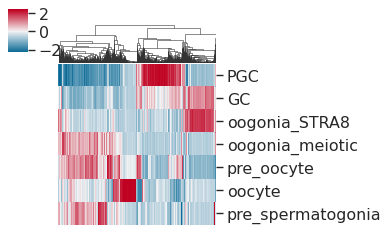

In [19]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, col_cluster = True, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(5, 3),
                         cmap = my_cmap)
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_germ/heatmap_germcells_clusters_sex.pdf")